In [1]:
from ultralytics import YOLO
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics.utils.ops import scale_image
model = YOLO('models/yolov8n-seg.pt')
from collections import Counter

In [15]:
def predict_on_image(model, img, conf):
    result = model(img, conf=conf)[0]
    if result.masks is None:
        return None, None, None, None, None
    # detection
    # result.boxes.xyxy   # box with xyxy format, (N, 4)
    cls = result.boxes.cls.cpu().numpy()    # cls, (N, 1)
    probs = result.boxes.conf.cpu().numpy()  # confidence score, (N, 1)
    boxes = result.boxes.xyxy.cpu().numpy()   # box with xyxy format, (N, 4)
    labels = result.names
    # segmentation
    masks = result.masks.data.cpu().numpy()     # masks, (N, H, W)
    masks = np.moveaxis(masks, 0, -1) # masks, (H, W, N)
    # rescale masks to original image
    masks = scale_image(masks, result.masks.orig_shape)
    masks = np.moveaxis(masks, -1, 0) # masks, (N, H, W)

    return boxes, masks, cls, probs, labels

In [3]:
def overlay(image, mask, color, alpha, resize=None):
    """Combines image and its segmentation mask into a single image.
    https://www.kaggle.com/code/purplejester/showing-samples-with-segmentation-mask-overlay

    Params:
        image: Training image. np.ndarray,
        mask: Segmentation mask. np.ndarray,
        color: Color for segmentation mask rendering.  tuple[int, int, int] = (255, 0, 0)
        alpha: Segmentation mask's transparency. float = 0.5,
        resize: If provided, both image and its mask are resized before blending them together.
        tuple[int, int] = (1024, 1024))

    Returns:
        image_combined: The combined image. np.ndarray

    """
    color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined

In [4]:
labels = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}
colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]

0: 640x640 3 dogs, 1 teddy bear, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


[(16, 3), (77, 1)]
{'dog': 3, 'teddy bear': 1}


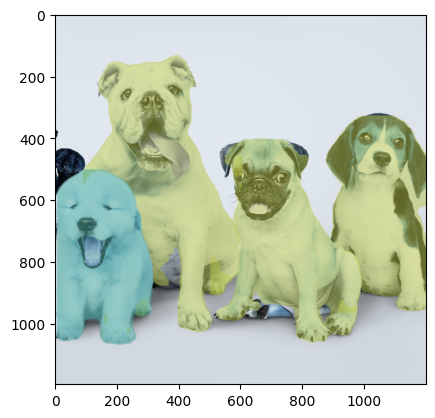

In [19]:
img = cv2.imread("dogs.jpg")

# predict by YOLOv8
boxes, masks, cls, probs, labels = predict_on_image(model, img, conf=0.55)
if masks is None:
    print("no detection")
else:
    counter = Counter(list(cls.astype("int")))
    output = list(counter.items())
    print
    output = dict(map(lambda x: (labels[x[0]],x[1]), output))

    # overlay masks on original image
    image_with_masks = np.copy(img)
    for i, mask in enumerate(masks):
        image_with_masks = overlay(image_with_masks, mask, color=colors[int(cls[i])], alpha=0.5)
    print(output)
    plt.imshow(image_with_masks)

In [17]:
import requests

url = "http://localhost:8000/vehicle_segment"
response = requests.post(url, json="monkey")
response.json()

'monkey'

In [22]:
counter = Counter(list(cls.astype("int")))
output = list(counter.items())

dict(map(lambda x: (labels[x[0]], str(x[1])), output))

{'dog': '3', 'teddy bear': '1'}